In [1]:
!pip install torch-geometric
!pip install umap-learn
!pip3 install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 900.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=7f87b648c73c79689567955dba01924423d024aeec51d95d45dac12da6780232
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
# Dataset

import torch.nn as nn

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]



Processing...
Done!


In [5]:
print(data.x.shape) # 노드 feature dimension이 1433
print(dataset.num_classes) # class 7

torch.Size([2708, 1433])
7


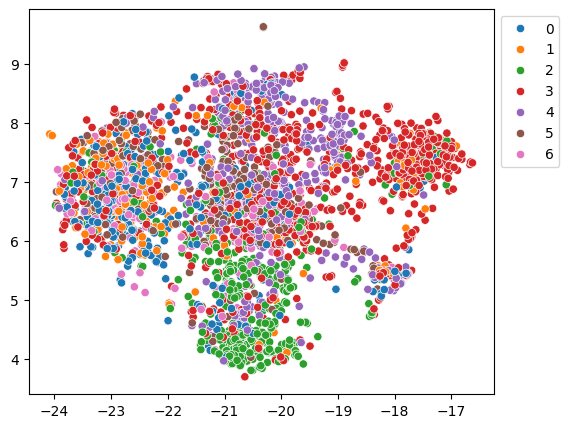

In [8]:
import umap.umap_ as umap
data_color = []

for y in data.y.numpy():
    data_color.append(f'C{y}')
embd = umap.UMAP().fit_transform(data.x.numpy())

palette = {}
for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

plt.figure(figsize=(6, 5))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_raw.png", dpi=120)

In [3]:
from torch_geometric.nn import GCNConv


class GCN(nn.Module):
  '''
  one-layer GCN
  속도를 위해 GCNConv 가져다 씀,,
  activation function은 논문에 나온대로 PReLU()
  '''
  def __init__(self, in_feats, n_out):
    super(GCN, self).__init__()
    self.gcn = GCNConv(in_feats, n_out)
    self.activation = nn.PReLU()

  def forward(self, x, a):
    h = self.gcn(x, a)
    out = self.activation(h)

    return out # n_out의 output


In [28]:
print(data.edge_index.shape)
print(data.num_nodes)
print(data.x.shape)

torch.Size([2, 10556])
2708
torch.Size([2708, 1433])


In [29]:
import torch
import torch.nn as nn
import torch.nn.init as init

def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

class DGI(nn.Module):
  def __init__(self, dataset = data, in_feats= 1433, n_classes = 7, out_feats = 256, lr = 5e-4, wd = 5e-4, epochs = 50): # 논문에서는 512 / 256
    super(DGI, self).__init__()
    self.gcn = GCN(in_feats, out_feats)
    self.lr = lr
    self.wd = wd
    self.dataset = dataset
    self.relu = nn.ReLU()
    self.criterion = nn.BCEWithLogitsLoss()
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=self.lr)
                                     # weight_decay= self.wd)
    self.epochs = epochs


    # For Discriminator
    self.W = nn.Parameter(torch.Tensor(out_feats, out_feats))
    init.xavier_uniform_(self.W)
    # bound = torch.sqrt(torch.tensor(out_feats, dtype=torch.float32))
    # self.W.data.uniform_(-bound, bound)

    # 나중에 classfier로 쓸 때 이거 학습시켜주면 됨 하지만 지금은,, 생략
    self.classifier = nn.Linear(out_feats, n_classes)


  def get_H(self):
    h = self.gcn(self.dataset.x, self.dataset.edge_index)
    return h

  def E(self, x, corrupt = False):
    # (N, F) => (N, F')
    if corrupt:
      h = self.C(x)
    # torch.Size([2708, 1433]) torch.Size([2708, 2708])
    h = self.gcn.forward(x, self.dataset.edge_index)

    return h

  def R(self, H):
    # Readout (Average)
    # (N, F) => (F)

    return torch.mean(H, dim = 0)

  def D(self, h, s):
    # Discriminator
    # h torch.Size([2708, 256]) s torch.Size([256]) w (256, 256) ( 2708, 256)이랑 (256)
    scores = torch.matmul(torch.matmul(h, self.W), s) # h: (N, out_feats) W : (out_feats, out_feats) => (N, out_feats) s: (out_feats,) => (out_feats, out_feats)으로 바꿔서 (N, out_Feats)끼리

    return torch.sigmoid(scores)

  def C(self, x):
    # Corruption
    n = x.shape[0]
    indices = torch.randperm(n)
    x_tilde = x[indices]

    return x_tilde

  def forward(self, x):
    # n개의 positive, m개의 negative
    # 이지만,, Transductive learning에서는 train data에 augmentation주니까 개수 똑같음

    pos_h = self.E(x)
    neg_h = self.E(x, corrupt = True)

    # print("Forward ", "pos", pos_h.shape, "neg", neg_h.shape)

    # summary vector
    s = self.R(pos_h)

    pos_prob = self.D(pos_h, s)
    neg_prob = self.D(neg_h, s)

    loss1 = self.criterion(pos_prob, torch.ones_like(pos_prob))
    loss2 = self.criterion(neg_prob, torch.zeros_like(neg_prob))

    loss = (loss1 + loss2) / 2 # 평균 내기

    return loss

  def fit(self):
    self.train()
    for epoch in range(self.epochs):

      self.optimizer.zero_grad()
      loss = self(self.dataset.x)
      loss.backward()
      self.optimizer.step()

      if(epoch % 10 == 0):

        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f}')


model = DGI()
print(model)
# Train
model.fit()


DGI(
  (gcn): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (relu): ReLU()
  (criterion): BCEWithLogitsLoss()
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 0.723
Epoch  10 | Train Loss: 0.702
Epoch  20 | Train Loss: 0.694
Epoch  30 | Train Loss: 0.693
Epoch  40 | Train Loss: 0.693


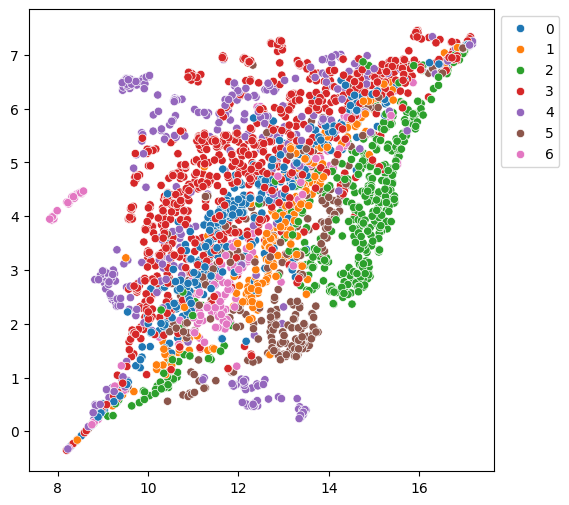

In [30]:
out_numpy = model.get_H().detach().cpu().numpy()
palette = {}

for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

???????????????????
학습이 된걸까..........


보통은 pos, neg concat해서 한번에 loss 계산 이게 더 빠름!